# Clustering for gevtev

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import cluster
from sklearn.decomposition.pca import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from definitions import *
from utils import *

In [2]:
#path_to_gamma_bins shoud contain an absolute path to your gamma-bins directory
path_to_gamma_bins = os.path.dirname(os.getcwd()) + "/"

In [3]:
#name columns included in the final display
other_names = ['gev_1FGL_Name', 'gev_CLASS1', 'tev_fermi_names', 'tev_classes', 's_MAIN_ID', 's_class','s_simbad', 'marked']
#from gamma bins directory
path_to_catalog = "markeddata/" + get_name_for_gevtev() + "_normalizedWITHOUT_LOG.txt"

In [4]:
spectra = pd.read_csv(path_to_gamma_bins + path_to_catalog, sep='\t')
print(path_to_gamma_bins +path_to_catalog)
spectra.head()

/home/masha/PycharmProjects/gamma-bins/markeddata/gevtev_simbadclasses_25_normalizedWITHOUT_LOG.txt


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,...,gev_GLAT,gev_RAJ2000,gev_DEJ2000,tev_fermi_names,tev_classes,tev_glat,tev_glon,tev_pos_dec,tev_pos_ra,marked
0,0.055155,0.201477,0.000004,0.235066,0.028249,0.0,0.391619,0.072840,0.013193,0.002028,...,-78.078400,3.4761,-18.896601,b'',b'hbl',-78.086937,74.632011,-18.901846,3.483564,0
1,0.069119,0.073172,0.003407,0.038325,0.145616,0.0,0.134072,0.020429,0.006452,0.059379,...,1.337755,6.4326,64.069298,b'',b'snr',1.412930,120.092361,64.140802,6.339723,0
2,0.358190,0.178179,0.096737,0.268908,0.097987,0.0,0.000000,0.000000,0.000000,0.000000,...,-81.224083,8.4022,-19.363800,b'',b'hbl',-81.216103,94.174644,-19.359207,8.393293,0
3,0.269005,0.157462,0.139724,0.220561,0.213247,0.0,0.000000,0.000000,0.000000,0.000000,...,-2.981383,8.9891,59.831799,b'',b'hbl',-2.978120,120.975426,59.834499,8.968984,0
4,0.079141,0.177705,0.320375,0.176376,0.246403,0.0,0.000000,0.000000,0.000000,0.000000,...,-87.951553,11.8866,-25.275000,b'',b'galaxy',-87.964546,97.363853,-25.288798,11.888062,0


In [5]:
spectra = spectra.copy()
spectra = spectra.reset_index(drop=True)

In [6]:
spectrum_columns = list_gev_spectrum_columns() + list_tev_spectrum_columns()

In [7]:
def get_distance_metric(metric_function):
    if type(metric_function) == str:
        dist = DistanceMetric.get_metric(metric_function)
    else:
        dist = DistanceMetric.get_metric("pyfunc", func=metric_function)
    return dist

In [8]:
from matplotlib import colors as mcolors


colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

In [9]:
colors = list(colors.values())[21:]

* ### earth mover's distance

In [10]:
# earth mover's distance
metric_function = st.wasserstein_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function, n_jobs=6)
# spectra_distances = get_distance_metric(metric_function).pairwise(spectra[spectrum_columns])
#pd.DataFrame(spectra_distances).to_csv(path_to_gamma_bins +"markeddata/gevtev_spectra_EM_distances.txt", index=False)

In [11]:
from utils import *

Clustering


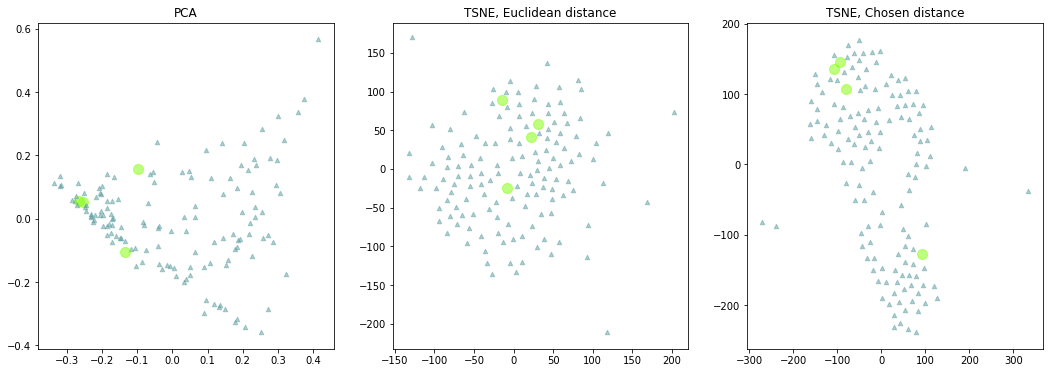

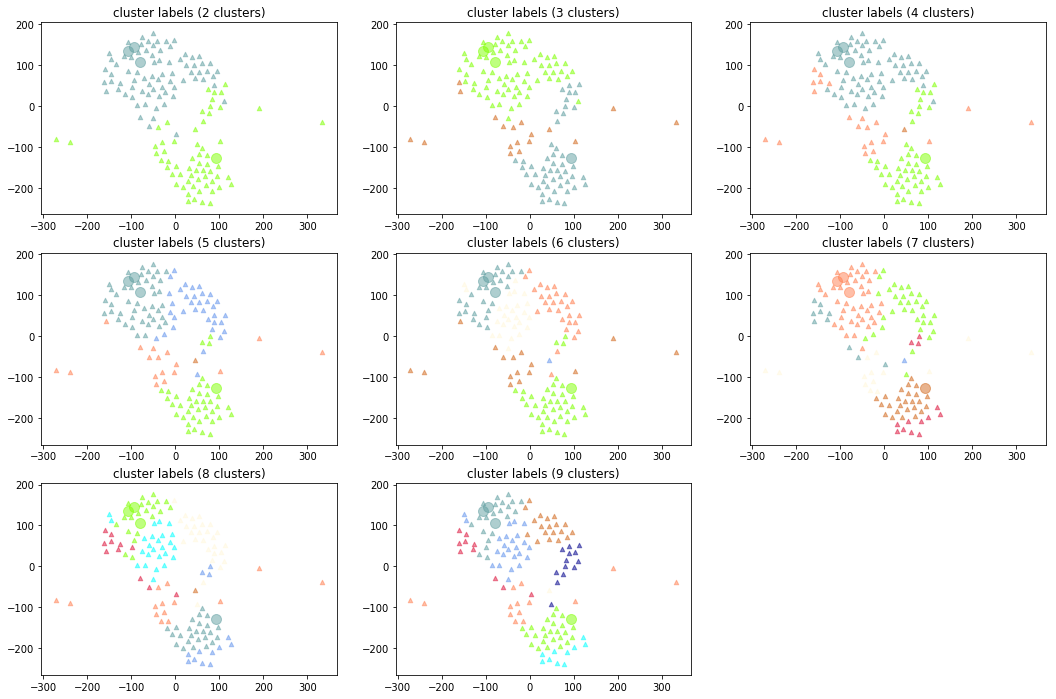

In [12]:
spectra_2D = build_images_KMeans(spectra, spectrum_columns, spectra_distances, colors, TSNE_learning_rate=700, TSNE_n_iter=340, TSNE_learning_rate2= 800)

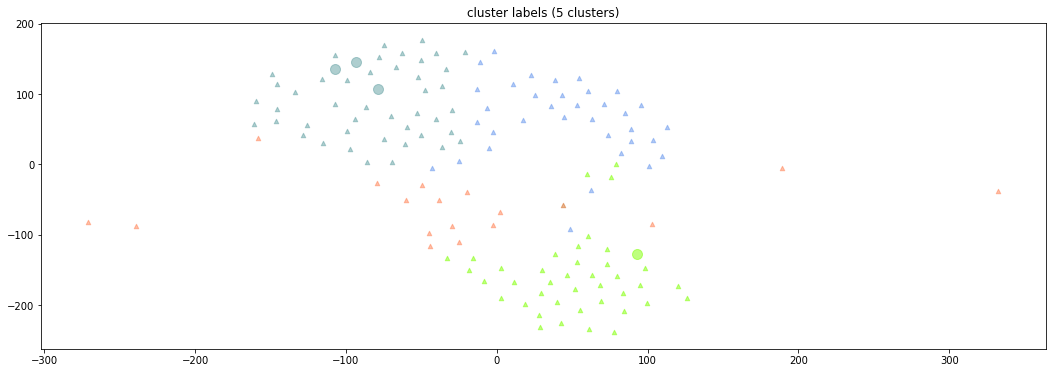

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,...,gev_RAJ2000,gev_DEJ2000,tev_fermi_names,tev_classes,tev_glat,tev_glon,tev_pos_dec,tev_pos_ra,marked,KMeans_clusters_5
12,0.014499,0.216198,0.331077,0.099187,0.322293,0.0,0.010681,0.002273,0.002087,0.000712,...,40.137901,61.228100,b'',b'bin',1.086135,135.675278,61.229336,40.131950,1,0
44,0.006512,0.225784,0.309710,0.088960,0.355733,0.0,0.003307,0.002040,0.001594,0.002120,...,154.729904,-58.945599,b'1FGL J1018.6-5856',b'bin',-1.779517,284.314087,-59.000001,154.575002,1,0
112,0.007598,0.117064,0.309349,0.034505,0.203540,0.0,0.118844,0.094852,0.067791,0.035185,...,276.568390,-14.847300,b'',b'bin',-1.289216,16.881586,-14.848400,276.562744,1,1
131,0.022409,0.362261,0.111730,0.253947,0.249653,0.0,0.000000,0.000000,0.000000,0.000000,...,308.059814,41.446899,b'',b'unid',1.111117,80.299477,41.567007,308.025009,1,0


0 cluster (#5F9EA0)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
0,b' ',b'bll ',b'',b'hbl',[],[],0,0
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',[],[],0,0
5,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',[],[],0,0
7,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',[],[],0,0
8,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',[],[],0,0
12,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',"[""b'BD+60 529'"" ""b'EM* MWC 56'"" ""b'LS I ...",['B' 'B' 'B0Ve' 'B0Ve'],1,1
14,b' ',b'rdg ',b'',b'hbl',[],[],0,0
16,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',[],[],0,0
23,b' ',b'PWN ',b'',b'psr',[],[],0,0
24,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',[],[],0,0


1 cluster (#7FFF00)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
6,b' ',b'bll ',b'',b'hbl',[],[],0,0
21,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',[],[],0,0
25,b' ',b'PWN ',b'',b'pwn',[],[],0,0
32,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',[],[],0,0
33,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',[],[],0,0
35,b' ',b'PWN ',b'',b'pwn',[],[],0,0
37,b'1FGL J0854.0-4632 ',b'SNR ',"b'1FGL J0854.0-4632,2FGL J0851.7-4635,3FGL J08...",b'snr',[],[],0,0
40,b' ',b'bll ',b'',b'hbl',[],[],0,0
47,b' ',b' ',b'',b'pwn',[],[],0,0
49,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',[],[],0,0


2 cluster (#D2691E)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
75,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',[],[],0,0


3 cluster (#FF7F50)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
1,b' ',b'snr ',b'',b'snr',[],[],0,0
11,b' ',b'bll ',b'',b'hbl',[],[],0,0
17,b' ',b'bll ',b'',b'hbl',[],[],0,0
20,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',[],[],0,0
22,b' ',b' ',b'',"b'snr,mc'","[""b'UCAC2 1674039'"" ""b'UCAC4 102-012036'"" ""b...",['Be' 'Be' 'B' 'B'],1,0
41,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',[],[],0,0
48,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',[],[],0,0
55,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',[],[],0,0
62,b'1FGL J1325.6-4300 ',b'RDG ',b'',b'fri',[],[],0,0
63,b' ',b'PSR ',b'',b'pwn',[],[],0,0


4 cluster (#6495ED)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',"[""b'LS I +59 48'""]",['B'],1,0
4,b'1FGL J0047.3-2512 ',b'sbg ',b'',b'galaxy',[],[],0,0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',[],[],0,0
10,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',[],[],0,0
13,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',[],[],0,0
15,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',[],[],0,0
18,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',[],[],0,0
19,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',[],[],0,0
26,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',[],[],0,0
28,b'1FGL J0617.2+2233 ',b'SNR ',b'',b'snr',"[""b'HD 43582'""]",['B0Ve'],1,0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.087398,0.245957,0.208679,0.152172,0.256879,0.0,0.027525,0.009618,0.005425,0.004084,0.002262
1,0.133994,0.116984,0.108041,0.114216,0.115702,0.0,0.151009,0.091886,0.070048,0.049174,0.048948
2,0.000057,0.000393,0.000838,0.000202,0.000636,0.0,0.000009,0.000187,0.002927,0.059691,0.935061
3,0.108567,0.071637,0.190584,0.067574,0.140167,0.0,0.145930,0.040927,0.030643,0.045311,0.158660
4,0.140368,0.196970,0.183298,0.188497,0.192405,0.0,0.063833,0.017953,0.010001,0.004880,0.001795


In [13]:
list_spectra_clusters, centers = print_clusters_structure_KMeans(spectra, spectrum_columns, other_names, spectra_distances, 5, colors,spectra_2D)
for i in range(len(list_spectra_clusters)):
    print("{} cluster ({})".format(i, colors[i]))
    display(list_spectra_clusters[i])
print("centroids:")
display(centers)

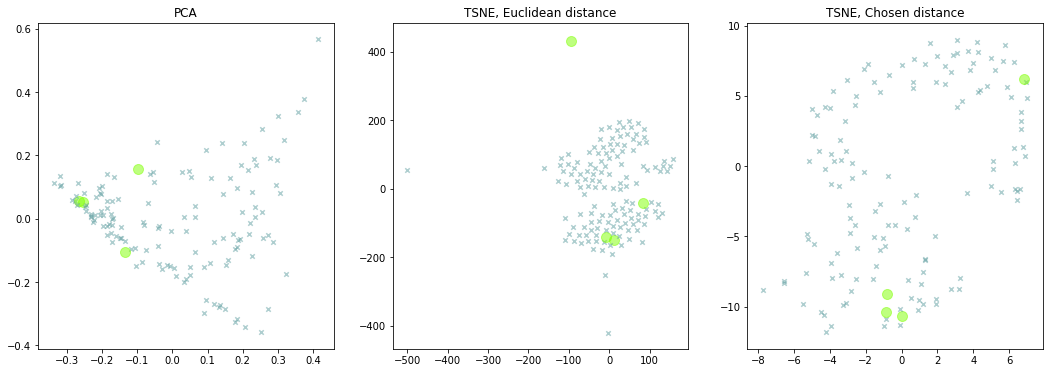

Clustering


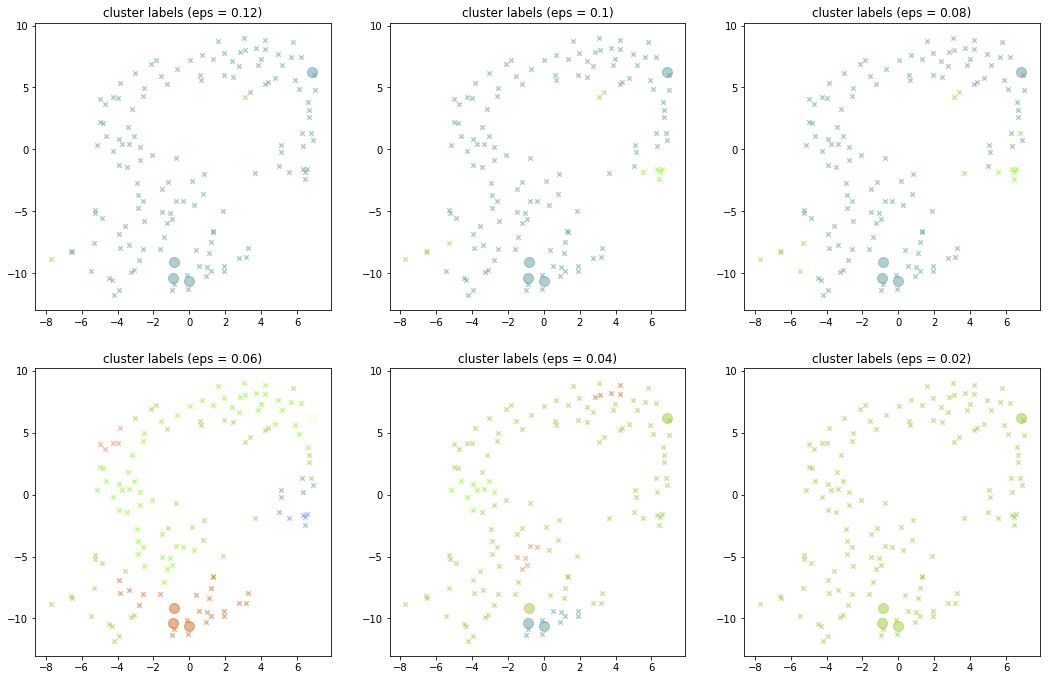

In [14]:
spectra_2D = build_images_DBSCAN(spectra, spectrum_columns, spectra_distances, colors, TSNE_learning_rate=500, TSNE_n_iter=1500, TSNE_learning_rate2=300)

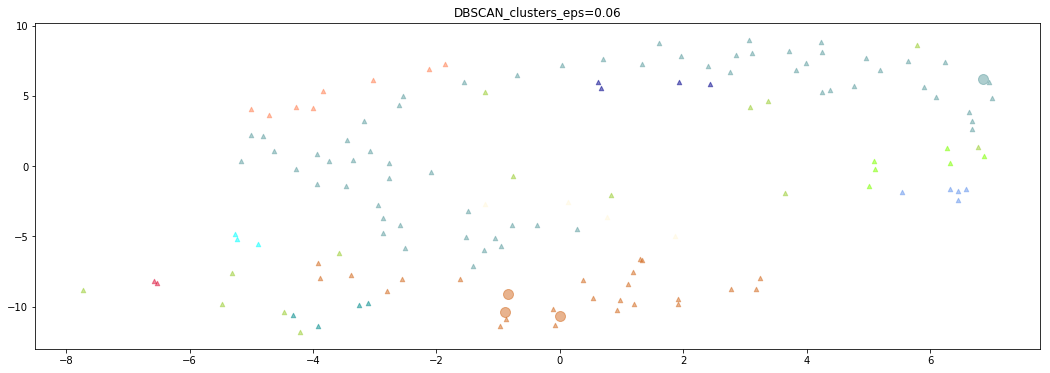

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,...,gev_RAJ2000,gev_DEJ2000,tev_fermi_names,tev_classes,tev_glat,tev_glon,tev_pos_dec,tev_pos_ra,marked,DBSCAN_clusters_eps=0.06
12,0.014499,0.216198,0.331077,0.099187,0.322293,0.0,0.010681,0.002273,0.002087,0.000712,...,40.137901,61.228100,b'',b'bin',1.086135,135.675278,61.229336,40.131950,1,2
44,0.006512,0.225784,0.309710,0.088960,0.355733,0.0,0.003307,0.002040,0.001594,0.002120,...,154.729904,-58.945599,b'1FGL J1018.6-5856',b'bin',-1.779517,284.314087,-59.000001,154.575002,1,2
112,0.007598,0.117064,0.309349,0.034505,0.203540,0.0,0.118844,0.094852,0.067791,0.035185,...,276.568390,-14.847300,b'',b'bin',-1.289216,16.881586,-14.848400,276.562744,1,0
131,0.022409,0.362261,0.111730,0.253947,0.249653,0.0,0.000000,0.000000,0.000000,0.000000,...,308.059814,41.446899,b'',b'unid',1.111117,80.299477,41.567007,308.025009,1,2


0 cluster (#5F9EA0)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
0,b' ',b'bll ',b'',b'hbl',[],[],0,0
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',[],[],0,0
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',"[""b'LS I +59 48'""]",['B'],1,0
4,b'1FGL J0047.3-2512 ',b'sbg ',b'',b'galaxy',[],[],0,0
6,b' ',b'bll ',b'',b'hbl',[],[],0,0
8,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',[],[],0,0
15,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',[],[],0,0
16,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',[],[],0,0
19,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',[],[],0,0
25,b' ',b'PWN ',b'',b'pwn',[],[],0,0


1 cluster (#7FFF00)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
1,b' ',b'snr ',b'',b'snr',[],[],0,0
55,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',[],[],0,0
63,b' ',b'PSR ',b'',b'pwn',[],[],0,0
76,b'1FGL J1513.2-5904 ',b'PSR ',b'',b'pwn',"[""b'Cl* Pismis 20 PPM 130'"" ""b'Cl Pis...",['B0Ve'],1,0
85,b' ',b'spp ',b'',b'pwn',[],[],0,0
140,b'1FGL J2359.0-3035 ',b'bll ',b'',b'hbl',[],[],0,0


2 cluster (#D2691E)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
7,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',[],[],0,0
12,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',"[""b'BD+60 529'"" ""b'EM* MWC 56'"" ""b'LS I ...",['B' 'B' 'B0Ve' 'B0Ve'],1,1
23,b' ',b'PWN ',b'',b'psr',[],[],0,0
24,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',[],[],0,0
29,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",[],[],0,0
36,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',[],[],0,0
42,b' ',b'PSR ',b'',b'pwn',[],[],0,0
43,b' ',b'PSR ',b'1FGL J1018.6-5856',b'bin',"[""b'2FGL J1019.0-5856'""]",['B0Ve'],2,0
44,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',"[""b'2FGL J1019.0-5856'""]",['B0Ve'],2,1
46,b'1FGL J1028.4-5819 ',b'PSR ',b'',b'pwn',[],[],0,0


3 cluster (#FF7F50)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',[],[],0,0
10,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',[],[],0,0
13,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',[],[],0,0
21,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',[],[],0,0
33,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',[],[],0,0
53,b'1FGL J1217.7+3007 ',b'bll ',b'',b'hbl',[],[],0,0
125,b'1FGL J2001.1+4351 ',b'bll ',b'',b'ibl',[],[],0,0
137,b'1FGL J2250.1+3825 ',b'bll ',b'',b'hbl',"[""b'FBS 2246+382'""]",['O'],1,0


4 cluster (#6495ED)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
17,b' ',b'bll ',b'',b'hbl',[],[],0,0
22,b' ',b' ',b'',"b'snr,mc'","[""b'UCAC2 1674039'"" ""b'UCAC4 102-012036'"" ""b...",['Be' 'Be' 'B' 'B'],1,0
41,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',[],[],0,0
48,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',[],[],0,0
79,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',[],[],0,0


5 cluster (#FFF8DC)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
18,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',[],[],0,0
66,b'1FGL J1420.1-6048 ',b'PSR ',b'',b'pwn',[],[],0,0
113,b' ',b' ',b'',b'bin',"[""b'LS IV -14 55'"" ""b'BD-14 5047'"" ""b'V* V...",['B' 'B0Ve' 'B0Ve'],1,0
133,b'1FGL J2202.8+4216 ',b'BLL ',b'',b'lbl',[],[],0,0


6 cluster (#DC143C)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
20,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',[],[],0,0
62,b'1FGL J1325.6-4300 ',b'RDG ',b'',b'fri',[],[],0,0


7 cluster (#00FFFF)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
27,b' ',b'bll ',b'',b'hbl',[],[],0,0
45,b'1FGL J1023.0-5746 ',b'PSR ',b'',b'unid',[],[],0,0
91,b'1FGL J1718.2-3825 ',b'PSR ',b'',b'pwn',"[""b'HD 323019'""]",['B0Ve'],1,0


8 cluster (#00008B)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
80,b'1FGL J1614.7-5138c',b'spp ',b'',b'unid',"[""b'MSX6C G331.5487-00.5364'"" ""b'MSX6C G331.54...",['Be' 'B' 'B0Ve'],1,0
84,b'1FGL J1640.8-4634c',b'spp ',b'',b'pwn',[],[],0,0
115,b'1FGL J1834.3-0842c',b'snr ',b'',b'unid',[],[],0,0
116,b' ',b'PWN ',b'',b'unid',"[""b'LS IV -05 11'"" ""b'[KRL2007b] 332'""]",['B' 'B0Ve'],1,0


9 cluster (#008B8B)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
98,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',"[""b'[DWC2011] 107'"" ""b'[DWC2011] 107'"" ""b'[MCD...",['Be' 'B' 'O' 'O'],1,0
99,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',"[""b'[DWC2011] 107'"" ""b'[DWC2011] 107'"" ""b'[MCD...",['Be' 'B' 'O' 'O'],1,0
117,b' ',b' ',b'',b'unid',"[""b'BD-03 4361'""]",['B'],1,0
119,b'1FGL J1853.1+0032c',b'psr ',b'',b'unid',[],[],0,0


10 cluster (#B8860B)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
5,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',[],[],0,0
11,b' ',b'bll ',b'',b'hbl',[],[],0,0
14,b' ',b'rdg ',b'',b'hbl',[],[],0,0
26,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',[],[],0,0
32,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',[],[],0,0
37,b'1FGL J0854.0-4632 ',b'SNR ',"b'1FGL J0854.0-4632,2FGL J0851.7-4635,3FGL J08...",b'snr',[],[],0,0
70,b'1FGL J1443.8+2457 ',b'fsrq ',b'3FGL J1443.9+2502',b'fsrq',[],[],0,0
71,b' ',b' ',b'',b'pwn',[],[],0,0
75,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',[],[],0,0
86,b' ',b'spp ',b'',b'unid',[],[],0,0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.136982,0.152244,0.161644,0.143311,0.158677,0.0,0.103038,0.050397,0.037292,0.027279,0.029136
1,0.038206,0.063323,0.209242,0.049515,0.123567,0.0,0.289924,0.076390,0.041288,0.026554,0.081991
2,0.061570,0.261221,0.229150,0.144588,0.285343,0.0,0.005537,0.004012,0.003496,0.003026,0.002056
3,0.182221,0.193188,0.172199,0.204489,0.174455,0.0,0.062836,0.008815,0.001486,0.000253,0.000057
4,0.169085,0.051186,0.011159,0.065171,0.039534,0.0,0.059296,0.024707,0.034945,0.113516,0.431401
5,0.074836,0.122234,0.131059,0.099952,0.132991,0.0,0.260218,0.087352,0.054534,0.028521,0.008302
6,0.301620,0.098718,0.307294,0.128982,0.163386,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.120656,0.246231,0.056028,0.203275,0.253175,0.0,0.063177,0.023957,0.015234,0.016821,0.001445
8,0.144378,0.174036,0.030223,0.160069,0.116076,0.0,0.123971,0.116220,0.082406,0.036032,0.016588
9,0.023000,0.302586,0.209252,0.139384,0.318476,0.0,0.004732,0.000266,0.000798,0.000592,0.000915


In [15]:
list_spectra_clusters, centers = print_clusters_structure_DBSCAN(spectra, spectrum_columns, other_names, spectra_distances, 0.06, colors, spectra_2D)
for i in range(len(list_spectra_clusters)):
    print("{} cluster ({})".format(i, colors[i]))
    display(list_spectra_clusters[i])
print("centroids:")
display(centers)

In [16]:
spectra_distances.min(), spectra_distances.max()

(0.0, 0.14346802126727987)

* ### euclidean distance

In [17]:
# euclidean distance
from scipy.spatial.distance import euclidean
metric_function = "euclidean"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)

In [18]:
spectra_distances.min(), spectra_distances.max()

(0.0, 1.13132861505431)

Clustering


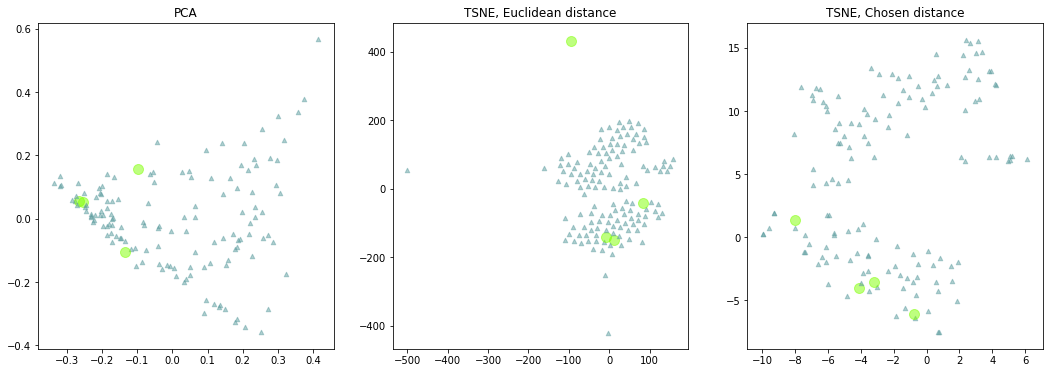

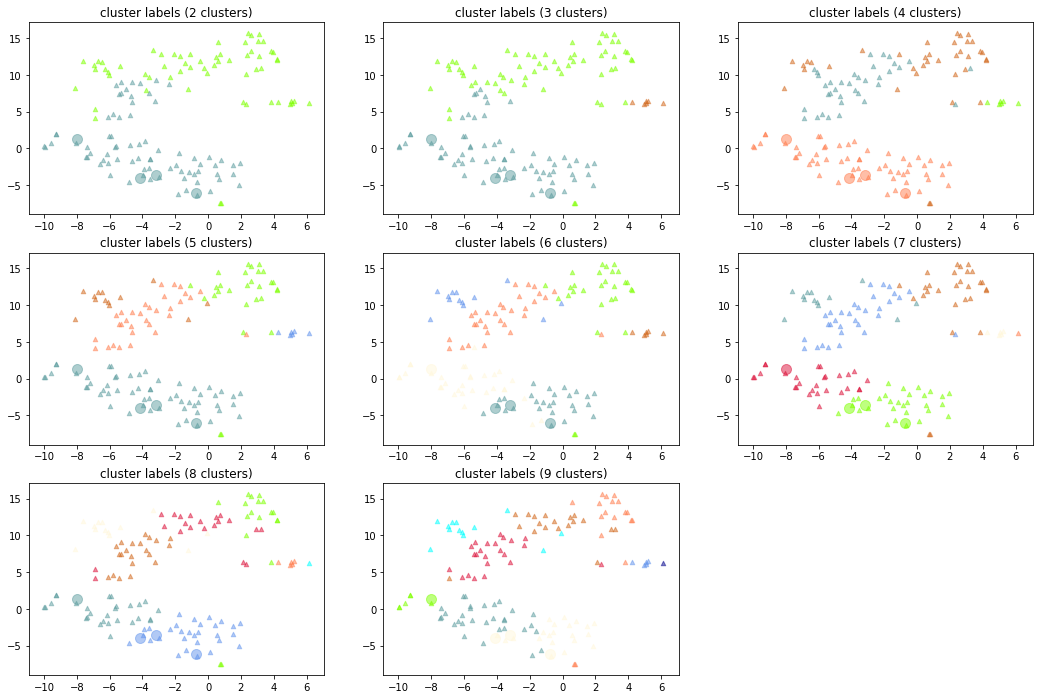

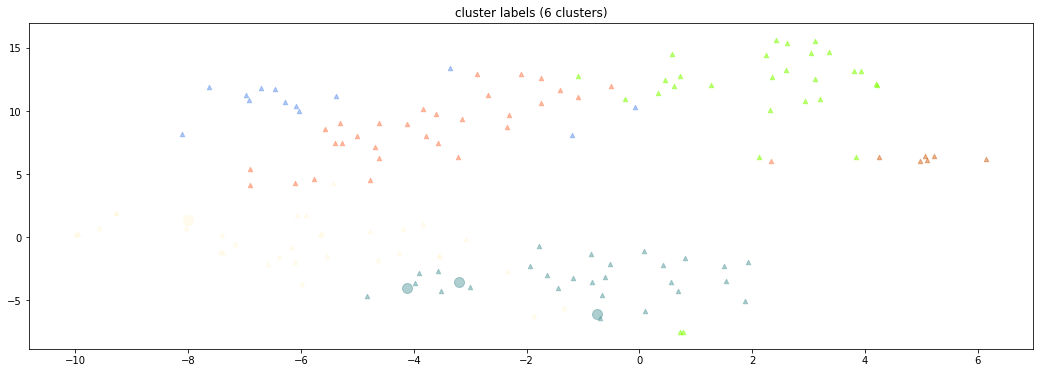

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,...,gev_RAJ2000,gev_DEJ2000,tev_fermi_names,tev_classes,tev_glat,tev_glon,tev_pos_dec,tev_pos_ra,marked,KMeans_clusters_6
12,0.014499,0.216198,0.331077,0.099187,0.322293,0.0,0.010681,0.002273,0.002087,0.000712,...,40.137901,61.228100,b'',b'bin',1.086135,135.675278,61.229336,40.131950,1,0
44,0.006512,0.225784,0.309710,0.088960,0.355733,0.0,0.003307,0.002040,0.001594,0.002120,...,154.729904,-58.945599,b'1FGL J1018.6-5856',b'bin',-1.779517,284.314087,-59.000001,154.575002,1,0
112,0.007598,0.117064,0.309349,0.034505,0.203540,0.0,0.118844,0.094852,0.067791,0.035185,...,276.568390,-14.847300,b'',b'bin',-1.289216,16.881586,-14.848400,276.562744,1,0
131,0.022409,0.362261,0.111730,0.253947,0.249653,0.0,0.000000,0.000000,0.000000,0.000000,...,308.059814,41.446899,b'',b'unid',1.111117,80.299477,41.567007,308.025009,1,5


0 cluster (#5F9EA0)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
4,b'1FGL J0047.3-2512 ',b'sbg ',b'',b'galaxy',[],[],0,0
7,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',[],[],0,0
8,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',[],[],0,0
12,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',"[""b'BD+60 529'"" ""b'EM* MWC 56'"" ""b'LS I ...",['B' 'B' 'B0Ve' 'B0Ve'],1,1
24,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',[],[],0,0
35,b' ',b'PWN ',b'',b'pwn',[],[],0,0
39,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',[],[],0,0
44,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',"[""b'2FGL J1019.0-5856'""]",['B0Ve'],2,1
50,b'1FGL J1119.4-6127c',b'PSR ',b'',b'pwn',[],[],0,0
57,b'1FGL J1224.7+2121 ',b'FSRQ ',b'',b'fsrq',[],[],0,0


1 cluster (#7FFF00)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
0,b' ',b'bll ',b'',b'hbl',[],[],0,0
6,b' ',b'bll ',b'',b'hbl',[],[],0,0
11,b' ',b'bll ',b'',b'hbl',[],[],0,0
18,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',[],[],0,0
25,b' ',b'PWN ',b'',b'pwn',[],[],0,0
30,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',[],[],0,0
32,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',[],[],0,0
37,b'1FGL J0854.0-4632 ',b'SNR ',"b'1FGL J0854.0-4632,2FGL J0851.7-4635,3FGL J08...",b'snr',[],[],0,0
40,b' ',b'bll ',b'',b'hbl',[],[],0,0
51,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',[],[],0,0


2 cluster (#D2691E)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
1,b' ',b'snr ',b'',b'snr',[],[],0,0
17,b' ',b'bll ',b'',b'hbl',[],[],0,0
41,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',[],[],0,0
48,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',[],[],0,0
75,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',[],[],0,0
79,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',[],[],0,0


3 cluster (#FF7F50)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',"[""b'LS I +59 48'""]",['B'],1,0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',[],[],0,0
10,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',[],[],0,0
13,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',[],[],0,0
19,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',[],[],0,0
21,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',[],[],0,0
33,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',[],[],0,0
34,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',[],[],0,0
47,b' ',b' ',b'',b'pwn',[],[],0,0
49,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',[],[],0,0


4 cluster (#6495ED)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',[],[],0,0
5,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',[],[],0,0
14,b' ',b'rdg ',b'',b'hbl',[],[],0,0
16,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',[],[],0,0
20,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',[],[],0,0
22,b' ',b' ',b'',"b'snr,mc'","[""b'UCAC2 1674039'"" ""b'UCAC4 102-012036'"" ""b...",['Be' 'Be' 'B' 'B'],1,0
23,b' ',b'PWN ',b'',b'psr',[],[],0,0
27,b' ',b'bll ',b'',b'hbl',[],[],0,0
31,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',[],[],0,0
36,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',[],[],0,0


5 cluster (#FFF8DC)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
15,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',[],[],0,0
26,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',[],[],0,0
28,b'1FGL J0617.2+2233 ',b'SNR ',b'',b'snr',"[""b'HD 43582'""]",['B0Ve'],1,0
29,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",[],[],0,0
38,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',"[""b'[CHP2004] J095549.8+693934'"" ""b'[MTK2001b]...",['B0Ve'],2,0
42,b' ',b'PSR ',b'',b'pwn',[],[],0,0
43,b' ',b'PSR ',b'1FGL J1018.6-5856',b'bin',"[""b'2FGL J1019.0-5856'""]",['B0Ve'],2,0
45,b'1FGL J1023.0-5746 ',b'PSR ',b'',b'unid',[],[],0,0
46,b'1FGL J1028.4-5819 ',b'PSR ',b'',b'pwn',[],[],0,0
58,b'1FGL J1230.8+1223 ',b'rdg ',b'',b'fri',[],[],0,0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.027481,0.173425,0.362165,0.087260,0.275464,0.0,0.026031,0.017780,0.013100,0.009989,0.007306
1,0.104602,0.081844,0.089417,0.086453,0.081975,0.0,0.263756,0.113048,0.080478,0.050355,0.048071
2,0.065013,0.034558,0.010000,0.041459,0.041370,0.0,0.066737,0.017971,0.023507,0.110672,0.588712
3,0.191341,0.171830,0.123009,0.195293,0.145589,0.0,0.080269,0.037145,0.024168,0.015719,0.015636
4,0.399042,0.164704,0.047170,0.236372,0.081918,0.0,0.022925,0.013262,0.014637,0.012300,0.007671
5,0.033258,0.281784,0.182991,0.156579,0.289367,0.0,0.025670,0.012521,0.008301,0.005697,0.003831


In [19]:
spectra_2D = build_images_KMeans(spectra, spectrum_columns, spectra_distances, colors, TSNE_learning_rate=500, TSNE_n_iter=1500, TSNE_learning_rate2=300)
list_spectra_clusters, centers = print_clusters_structure_KMeans(spectra, spectrum_columns, other_names, spectra_distances, 6, colors, spectra_2D)
for i in range(len(list_spectra_clusters)):
    print("{} cluster ({})".format(i, colors[i]))
    display(list_spectra_clusters[i])
print("centroids:")
display(centers)

[1.2000000000000002, 1.0, 0.8, 0.6000000000000001, 0.4, 0.2, 0.1]


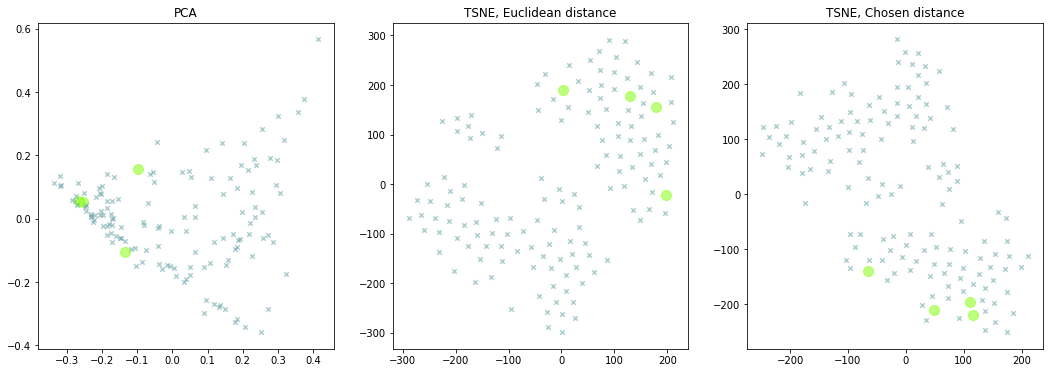

Clustering


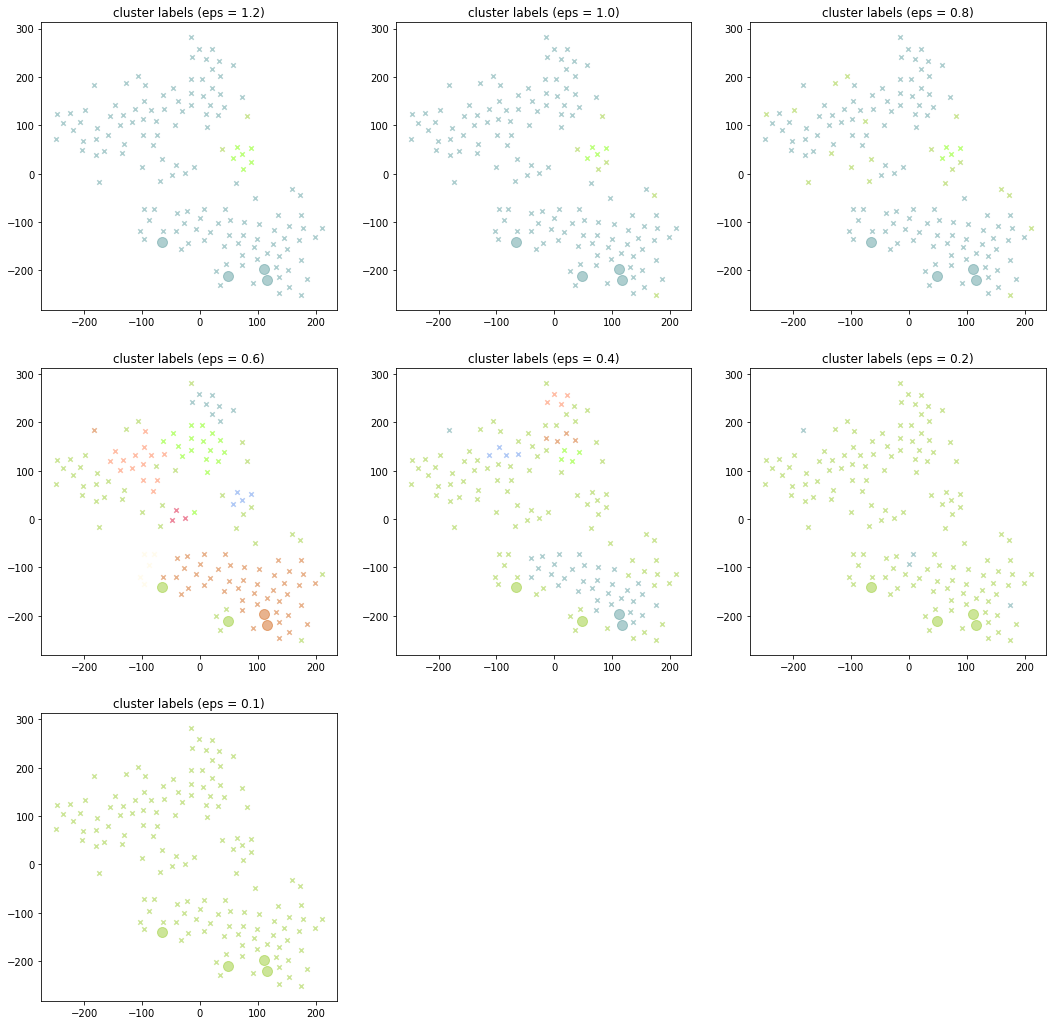

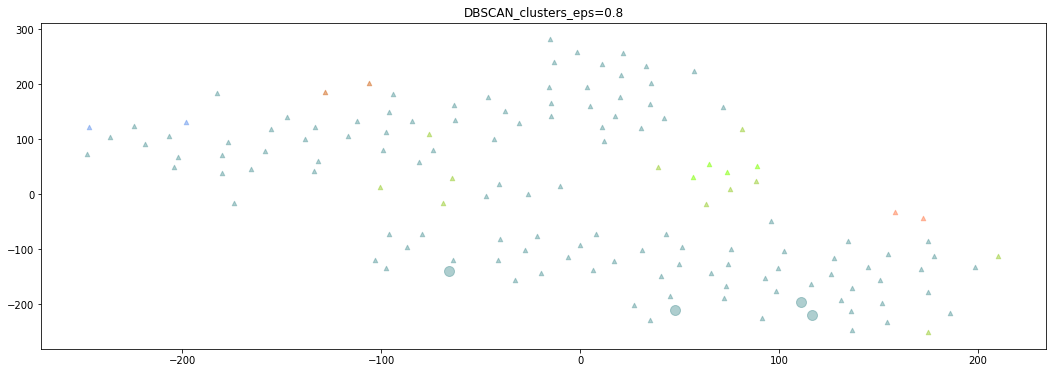

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,...,gev_RAJ2000,gev_DEJ2000,tev_fermi_names,tev_classes,tev_glat,tev_glon,tev_pos_dec,tev_pos_ra,marked,DBSCAN_clusters_eps=0.8
12,0.014499,0.216198,0.331077,0.099187,0.322293,0.0,0.010681,0.002273,0.002087,0.000712,...,40.137901,61.228100,b'',b'bin',1.086135,135.675278,61.229336,40.131950,1,0
44,0.006512,0.225784,0.309710,0.088960,0.355733,0.0,0.003307,0.002040,0.001594,0.002120,...,154.729904,-58.945599,b'1FGL J1018.6-5856',b'bin',-1.779517,284.314087,-59.000001,154.575002,1,0
112,0.007598,0.117064,0.309349,0.034505,0.203540,0.0,0.118844,0.094852,0.067791,0.035185,...,276.568390,-14.847300,b'',b'bin',-1.289216,16.881586,-14.848400,276.562744,1,0
131,0.022409,0.362261,0.111730,0.253947,0.249653,0.0,0.000000,0.000000,0.000000,0.000000,...,308.059814,41.446899,b'',b'unid',1.111117,80.299477,41.567007,308.025009,1,0


0 cluster (#5F9EA0)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
0,b' ',b'bll ',b'',b'hbl',[],[],0,0
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',[],[],0,0
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',"[""b'LS I +59 48'""]",['B'],1,0
4,b'1FGL J0047.3-2512 ',b'sbg ',b'',b'galaxy',[],[],0,0
5,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',[],[],0,0
6,b' ',b'bll ',b'',b'hbl',[],[],0,0
7,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',[],[],0,0
8,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',[],[],0,0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',[],[],0,0
10,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',[],[],0,0


1 cluster (#7FFF00)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
17,b' ',b'bll ',b'',b'hbl',[],[],0,0
41,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',[],[],0,0
48,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',[],[],0,0
79,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',[],[],0,0


2 cluster (#D2691E)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
60,b' ',b'PWN ',b'',b'pwn',[],[],0,0
68,b'1FGL J1428.7+4239 ',b'bll ',b'',b'hbl',[],[],0,0


3 cluster (#FF7F50)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
74,b' ',b' ',b'',b'unid',[],[],0,0
76,b'1FGL J1513.2-5904 ',b'PSR ',b'',b'pwn',"[""b'Cl* Pismis 20 PPM 130'"" ""b'Cl Pis...",['B0Ve'],1,0


4 cluster (#6495ED)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
82,b'1FGL J1626.0-4917c',b' ',b'',b'unid',[],[],0,0
133,b'1FGL J2202.8+4216 ',b'BLL ',b'',b'lbl',[],[],0,0


5 cluster (#FFF8DC)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
1,b' ',b'snr ',b'',b'snr',[],[],0,0
14,b' ',b'rdg ',b'',b'hbl',[],[],0,0
16,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',[],[],0,0
40,b' ',b'bll ',b'',b'hbl',[],[],0,0
47,b' ',b' ',b'',b'pwn',[],[],0,0
62,b'1FGL J1325.6-4300 ',b'RDG ',b'',b'fri',[],[],0,0
71,b' ',b' ',b'',b'pwn',[],[],0,0
75,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',[],[],0,0
78,b'1FGL J1517.8-2423 ',b'bll ',b'',b'lbl',[],[],0,0
104,b'1FGL J1803.1-2147c',b'PSR ',b'',b'unid',[],[],0,0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.119023,0.186662,0.177792,0.148698,0.197416,0.0,0.084188,0.037993,0.024933,0.014451,0.008845
1,0.080226,0.033446,0.013939,0.052557,0.025492,0.0,0.066585,0.021803,0.032917,0.136241,0.536796
2,0.257098,0.070366,0.004147,0.057641,0.061719,0.0,0.029570,0.115452,0.183021,0.157080,0.063906
3,0.051211,0.034083,0.402441,0.033795,0.042715,0.0,0.163029,0.101770,0.080837,0.058700,0.031420
4,0.029337,0.081158,0.212772,0.054826,0.133726,0.0,0.323275,0.071834,0.035809,0.031051,0.026210
5,0.098275,0.142187,0.114939,0.112256,0.151505,0.0,0.072666,0.029017,0.025264,0.039647,0.214244


In [20]:
eps_l = [0.1 * i for i in range(12, 0, -2)] + [0.1]
print(eps_l)
spectra_2D = build_images_DBSCAN(spectra, spectrum_columns, spectra_distances, colors, eps_l=eps_l, TSNE_learning_rate=1000, TSNE_n_iter=1500, TSNE_learning_rate2=900)
list_spectra_clusters, centers = print_clusters_structure_DBSCAN(spectra, spectrum_columns, other_names, spectra_distances, 0.8, colors, spectra_2D)
for i in range(len(list_spectra_clusters)):
    print("{} cluster ({})".format(i, colors[i]))
    display(list_spectra_clusters[i])
print("centroids:")
display(centers)

* ### cosine distance

In [21]:
# cosine distance
# from scipy.spatial.distance import cosine
metric_function = "cosine"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)

Clustering


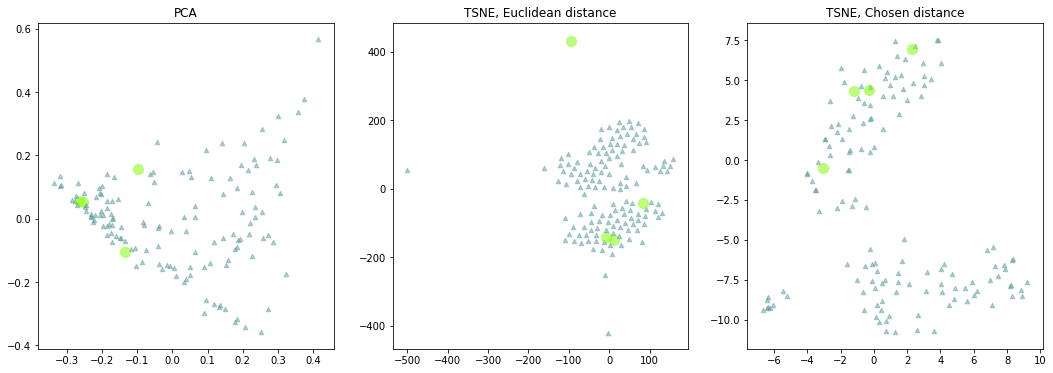

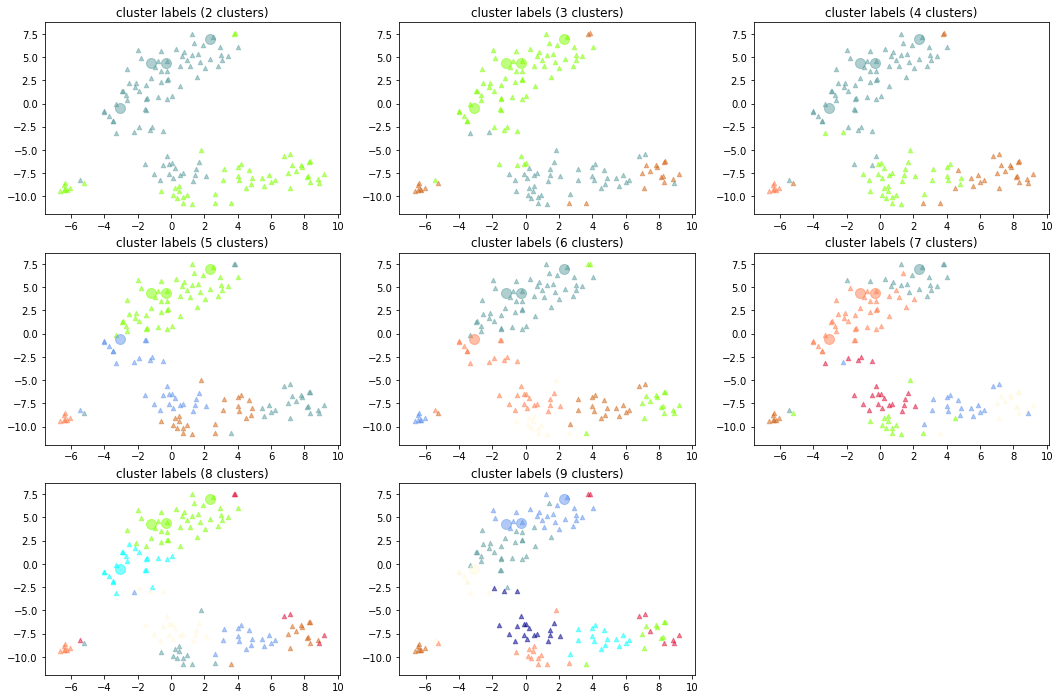

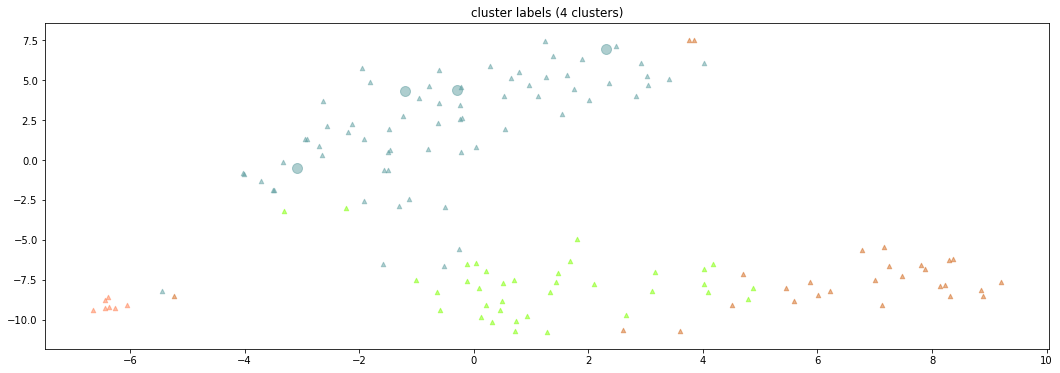

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,...,gev_RAJ2000,gev_DEJ2000,tev_fermi_names,tev_classes,tev_glat,tev_glon,tev_pos_dec,tev_pos_ra,marked,KMeans_clusters_4
12,0.014499,0.216198,0.331077,0.099187,0.322293,0.0,0.010681,0.002273,0.002087,0.000712,...,40.137901,61.228100,b'',b'bin',1.086135,135.675278,61.229336,40.131950,1,0
44,0.006512,0.225784,0.309710,0.088960,0.355733,0.0,0.003307,0.002040,0.001594,0.002120,...,154.729904,-58.945599,b'1FGL J1018.6-5856',b'bin',-1.779517,284.314087,-59.000001,154.575002,1,0
112,0.007598,0.117064,0.309349,0.034505,0.203540,0.0,0.118844,0.094852,0.067791,0.035185,...,276.568390,-14.847300,b'',b'bin',-1.289216,16.881586,-14.848400,276.562744,1,0
131,0.022409,0.362261,0.111730,0.253947,0.249653,0.0,0.000000,0.000000,0.000000,0.000000,...,308.059814,41.446899,b'',b'unid',1.111117,80.299477,41.567007,308.025009,1,0


0 cluster (#5F9EA0)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
4,b'1FGL J0047.3-2512 ',b'sbg ',b'',b'galaxy',[],[],0,0
7,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',[],[],0,0
8,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',[],[],0,0
12,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',"[""b'BD+60 529'"" ""b'EM* MWC 56'"" ""b'LS I ...",['B' 'B' 'B0Ve' 'B0Ve'],1,1
15,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',[],[],0,0
24,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',[],[],0,0
26,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',[],[],0,0
28,b'1FGL J0617.2+2233 ',b'SNR ',b'',b'snr',"[""b'HD 43582'""]",['B0Ve'],1,0
29,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",[],[],0,0
33,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',[],[],0,0


1 cluster (#7FFF00)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',[],[],0,0
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',"[""b'LS I +59 48'""]",['B'],1,0
5,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',[],[],0,0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',[],[],0,0
10,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',[],[],0,0
13,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',[],[],0,0
14,b' ',b'rdg ',b'',b'hbl',[],[],0,0
19,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',[],[],0,0
20,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',[],[],0,0
21,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',[],[],0,0


2 cluster (#D2691E)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
0,b' ',b'bll ',b'',b'hbl',[],[],0,0
6,b' ',b'bll ',b'',b'hbl',[],[],0,0
11,b' ',b'bll ',b'',b'hbl',[],[],0,0
16,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',[],[],0,0
18,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',[],[],0,0
25,b' ',b'PWN ',b'',b'pwn',[],[],0,0
32,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',[],[],0,0
37,b'1FGL J0854.0-4632 ',b'SNR ',"b'1FGL J0854.0-4632,2FGL J0851.7-4635,3FGL J08...",b'snr',[],[],0,0
40,b' ',b'bll ',b'',b'hbl',[],[],0,0
51,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',[],[],0,0


3 cluster (#FF7F50)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
1,b' ',b'snr ',b'',b'snr',[],[],0,0
17,b' ',b'bll ',b'',b'hbl',[],[],0,0
41,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',[],[],0,0
48,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',[],[],0,0
75,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',[],[],0,0
79,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',[],[],0,0
109,b' ',b' ',b'',b'pwn',"[""b'[MCF2015] 22'""]",['O'],2,0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.039466,0.225975,0.259511,0.129818,0.271927,0.0,0.029308,0.015616,0.010829,0.008372,0.009179
1,0.272775,0.169788,0.088194,0.216109,0.121757,0.0,0.065907,0.029070,0.019479,0.011433,0.005488
2,0.120646,0.079038,0.089039,0.084883,0.076251,0.0,0.260496,0.114869,0.082628,0.053713,0.038436
3,0.057055,0.046399,0.008572,0.048197,0.054512,0.0,0.068851,0.026817,0.032564,0.101037,0.555995


In [22]:
spectra_2D = build_images_KMeans(spectra, spectrum_columns, spectra_distances, colors, TSNE_learning_rate=500, TSNE_n_iter=1500, TSNE_learning_rate2=300)
list_spectra_clusters, centers = print_clusters_structure_KMeans(spectra, spectrum_columns, other_names, spectra_distances, 4, colors, spectra_2D)
for i in range(len(list_spectra_clusters)):
    print("{} cluster ({})".format(i, colors[i]))
    display(list_spectra_clusters[i])
print("centroids:")
display(centers)

<Figure size 432x288 with 0 Axes>

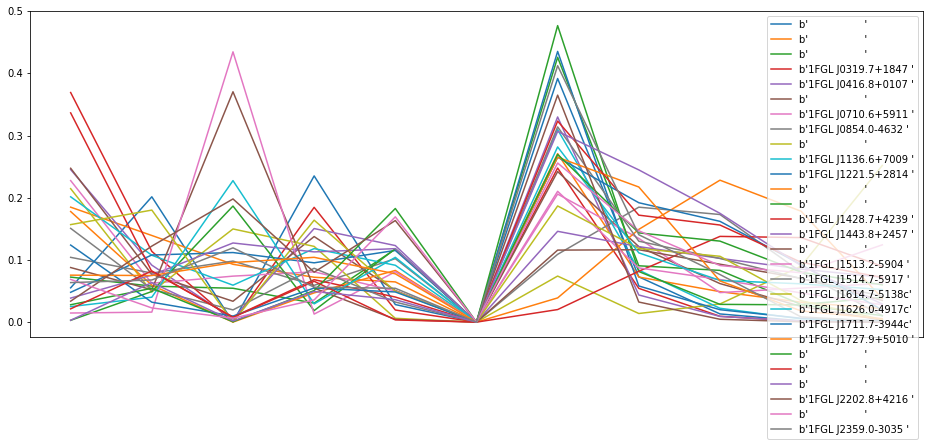

In [23]:
marked_cluster = list_spectra_clusters[2]
show_all_spectra(spectrum_columns, spectra.iloc[list(marked_cluster.index)])

[1.0, 0.8, 0.6000000000000001, 0.4, 0.2, 0.1]


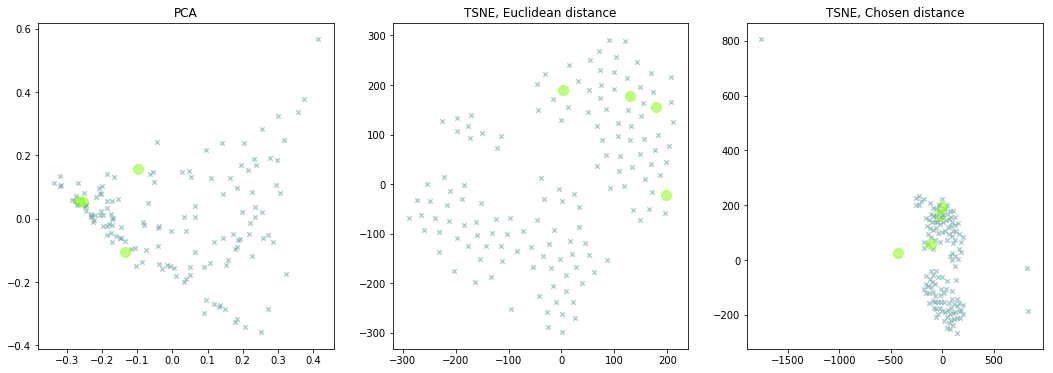

Clustering


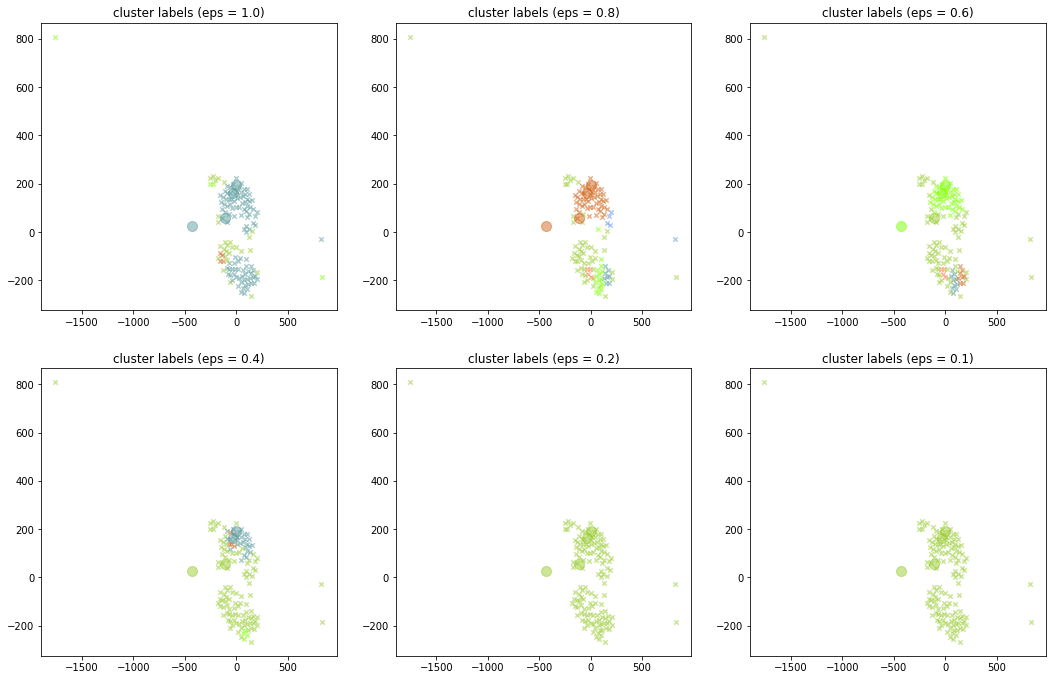

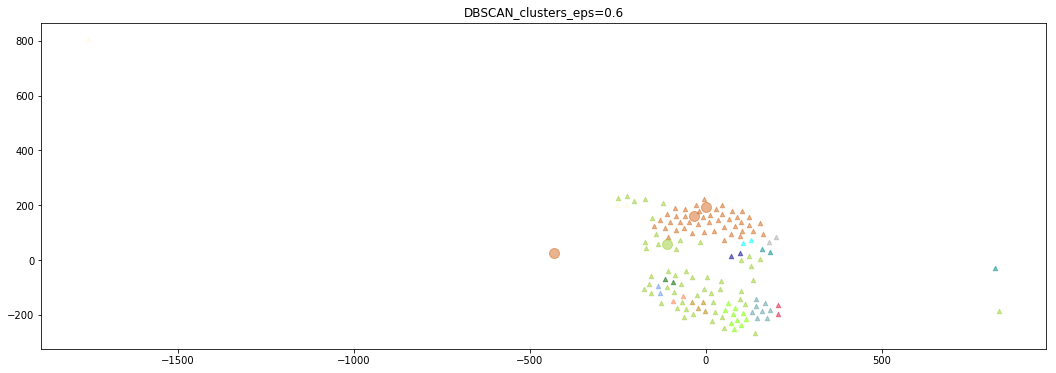

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,...,gev_RAJ2000,gev_DEJ2000,tev_fermi_names,tev_classes,tev_glat,tev_glon,tev_pos_dec,tev_pos_ra,marked,DBSCAN_clusters_eps=0.6
12,0.014499,0.216198,0.331077,0.099187,0.322293,0.0,0.010681,0.002273,0.002087,0.000712,...,40.137901,61.228100,b'',b'bin',1.086135,135.675278,61.229336,40.131950,1,2
44,0.006512,0.225784,0.309710,0.088960,0.355733,0.0,0.003307,0.002040,0.001594,0.002120,...,154.729904,-58.945599,b'1FGL J1018.6-5856',b'bin',-1.779517,284.314087,-59.000001,154.575002,1,2
112,0.007598,0.117064,0.309349,0.034505,0.203540,0.0,0.118844,0.094852,0.067791,0.035185,...,276.568390,-14.847300,b'',b'bin',-1.289216,16.881586,-14.848400,276.562744,1,-1
131,0.022409,0.362261,0.111730,0.253947,0.249653,0.0,0.000000,0.000000,0.000000,0.000000,...,308.059814,41.446899,b'',b'unid',1.111117,80.299477,41.567007,308.025009,1,2


0 cluster (#5F9EA0)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',[],[],0,0
5,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',[],[],0,0
23,b' ',b'PWN ',b'',b'psr',[],[],0,0
27,b' ',b'bll ',b'',b'hbl',[],[],0,0
31,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',[],[],0,0
36,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',[],[],0,0
54,b'1FGL J1221.3+3008 ',b'bll ',b'',b'hbl',[],[],0,0
136,b'1FGL J2244.0+2021 ',b'bll ',b'',b'ibl',[],[],0,0


1 cluster (#7FFF00)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',"[""b'LS I +59 48'""]",['B'],1,0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',[],[],0,0
10,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',[],[],0,0
13,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',[],[],0,0
19,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',[],[],0,0
34,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',[],[],0,0
67,b'1FGL J1426.9+2347 ',b'BLL ',b'',b'hbl',"[""b'KUV 14240+2402'""]",['B'],1,0
124,b'1FGL J2000.0+6508 ',b'bll ',b'',b'hbl',[],[],0,0
125,b'1FGL J2001.1+4351 ',b'bll ',b'',b'ibl',[],[],0,0
132,b'1FGL J2158.8-3013 ',b'bll ',b'',b'hbl',[],[],0,0


2 cluster (#D2691E)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
4,b'1FGL J0047.3-2512 ',b'sbg ',b'',b'galaxy',[],[],0,0
7,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',[],[],0,0
8,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',[],[],0,0
12,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',"[""b'BD+60 529'"" ""b'EM* MWC 56'"" ""b'LS I ...",['B' 'B' 'B0Ve' 'B0Ve'],1,1
15,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',[],[],0,0
24,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',[],[],0,0
26,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',[],[],0,0
29,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",[],[],0,0
38,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',"[""b'[CHP2004] J095549.8+693934'"" ""b'[MTK2001b]...",['B0Ve'],2,0
39,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',[],[],0,0


3 cluster (#FF7F50)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
6,b' ',b'bll ',b'',b'hbl',[],[],0,0
51,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',[],[],0,0


4 cluster (#6495ED)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
11,b' ',b'bll ',b'',b'hbl',[],[],0,0
140,b'1FGL J2359.0-3035 ',b'bll ',b'',b'hbl',[],[],0,0


5 cluster (#FFF8DC)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
17,b' ',b'bll ',b'',b'hbl',[],[],0,0
41,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',[],[],0,0
48,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',[],[],0,0


6 cluster (#DC143C)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
20,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',[],[],0,0
22,b' ',b' ',b'',"b'snr,mc'","[""b'UCAC2 1674039'"" ""b'UCAC4 102-012036'"" ""b...",['Be' 'Be' 'B' 'B'],1,0


7 cluster (#00FFFF)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
28,b'1FGL J0617.2+2233 ',b'SNR ',b'',b'snr',"[""b'HD 43582'""]",['B0Ve'],1,0
58,b'1FGL J1230.8+1223 ',b'rdg ',b'',b'fri',[],[],0,0


8 cluster (#00008B)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
33,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',[],[],0,0
105,b'1FGL J1805.2-2137c',b'SNR ',b'',b'unid',[],[],0,0


9 cluster (#008B8B)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
45,b'1FGL J1023.0-5746 ',b'PSR ',b'',b'unid',[],[],0,0
91,b'1FGL J1718.2-3825 ',b'PSR ',b'',b'pwn',"[""b'HD 323019'""]",['B0Ve'],1,0
96,b' ',b' ',b'',b'unid',"[""b'SSTGC 519103'"" ""b'SSTGC 519103'"" ""b'GCIRS ...",['Be' 'B' 'B' 'O'],1,0


10 cluster (#B8860B)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
49,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',[],[],0,0
94,b'1FGL J1744.2+1934 ',b'bll ',b'',b'hbl',[],[],0,0
126,b'1FGL J2009.5-4849 ',b'BLL ',b'',b'hbl',[],[],0,0
139,b'1FGL J2347.1+5142 ',b'bll ',b'',b'hbl',[],[],0,0


11 cluster (#A9A9A9)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
98,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',"[""b'[DWC2011] 107'"" ""b'[DWC2011] 107'"" ""b'[MCD...",['Be' 'B' 'O' 'O'],1,0
99,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',"[""b'[DWC2011] 107'"" ""b'[DWC2011] 107'"" ""b'[MCD...",['Be' 'B' 'O' 'O'],1,0


12 cluster (#006400)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
107,b' ',b'spp ',b'',b'unid',"[""b'Hen 3-1611'""]",['B'],1,0
113,b' ',b' ',b'',b'bin',"[""b'LS IV -14 55'"" ""b'BD-14 5047'"" ""b'V* V...",['B' 'B0Ve' 'B0Ve'],1,0


13 cluster (#A9A9A9)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
0,b' ',b'bll ',b'',b'hbl',[],[],0,0
1,b' ',b'snr ',b'',b'snr',[],[],0,0
14,b' ',b'rdg ',b'',b'hbl',[],[],0,0
16,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',[],[],0,0
18,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',[],[],0,0
21,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',[],[],0,0
25,b' ',b'PWN ',b'',b'pwn',[],[],0,0
30,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',[],[],0,0
32,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',[],[],0,0
35,b' ',b'PWN ',b'',b'pwn',[],[],0,0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.397970,0.159093,0.071110,0.270115,0.101712,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,0.235835,0.189236,0.137917,0.222833,0.167239,0.0,0.031473,0.006954,0.004899,0.003075,5.387074e-04
2,0.028293,0.231885,0.292045,0.123692,0.287613,0.0,0.015227,0.008204,0.005875,0.004375,2.790307e-03
3,0.193137,0.123400,0.076174,0.095189,0.078047,0.0,0.290182,0.078053,0.035650,0.018621,1.154631e-02
4,0.067972,0.062820,0.086944,0.043334,0.085838,0.0,0.418987,0.115550,0.079861,0.018375,2.031949e-02
5,0.061476,0.026688,0.011000,0.040490,0.021469,0.0,0.080185,0.028454,0.040043,0.153042,5.371522e-01
6,0.547815,0.108563,0.017778,0.159250,0.095614,0.0,0.015071,0.018160,0.021529,0.011310,4.910690e-03
7,0.080584,0.264073,0.157564,0.234452,0.255152,0.0,0.006937,0.001143,0.000089,0.000005,4.274064e-07
8,0.087830,0.214296,0.166016,0.169494,0.209164,0.0,0.112792,0.025872,0.009031,0.003619,1.886326e-03
9,0.009717,0.340783,0.016948,0.134951,0.356095,0.0,0.071319,0.030563,0.019690,0.018340,1.593863e-03


In [24]:
eps_l = [0.1 * i for i in range(10, 0, -2)] + [0.1]
print(eps_l)
spectra_2D = build_images_DBSCAN(spectra, spectrum_columns, spectra_distances, colors, eps_l=eps_l, TSNE_learning_rate=1000, TSNE_n_iter=1500, TSNE_learning_rate2=900)
list_spectra_clusters, centers = print_clusters_structure_DBSCAN(spectra, spectrum_columns, other_names, spectra_distances, 0.6, colors, spectra_2D)
for i in range(len(list_spectra_clusters)):
    print("{} cluster ({})".format(i, colors[i]))
    display(list_spectra_clusters[i])
print("centroids:")
display(centers)

<Figure size 432x288 with 0 Axes>

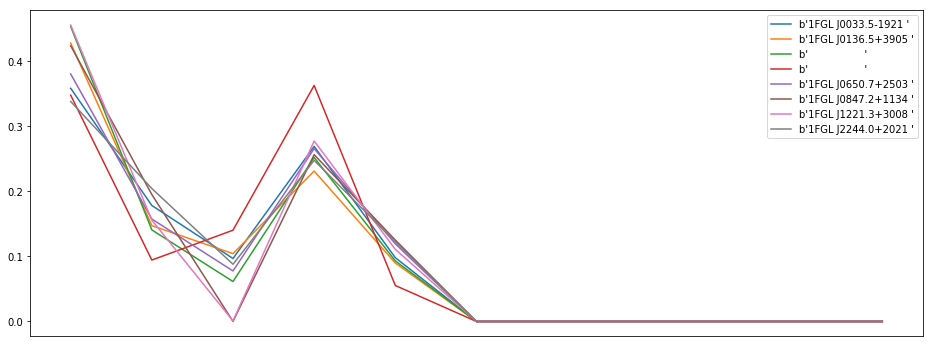

In [25]:
marked_cluster = list_spectra_clusters[0]
show_all_spectra(spectrum_columns, spectra.iloc[list(marked_cluster.index)])

* ### energy distance

In [26]:
# energy distance
metric_function = st.energy_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)

In [27]:
spectra_distances.min(), spectra_distances.max()

(0.0, 0.32025841730627447)

Clustering


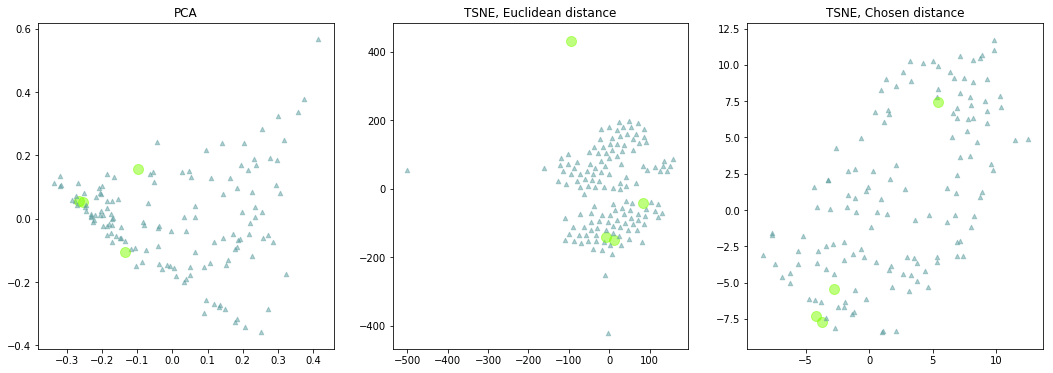

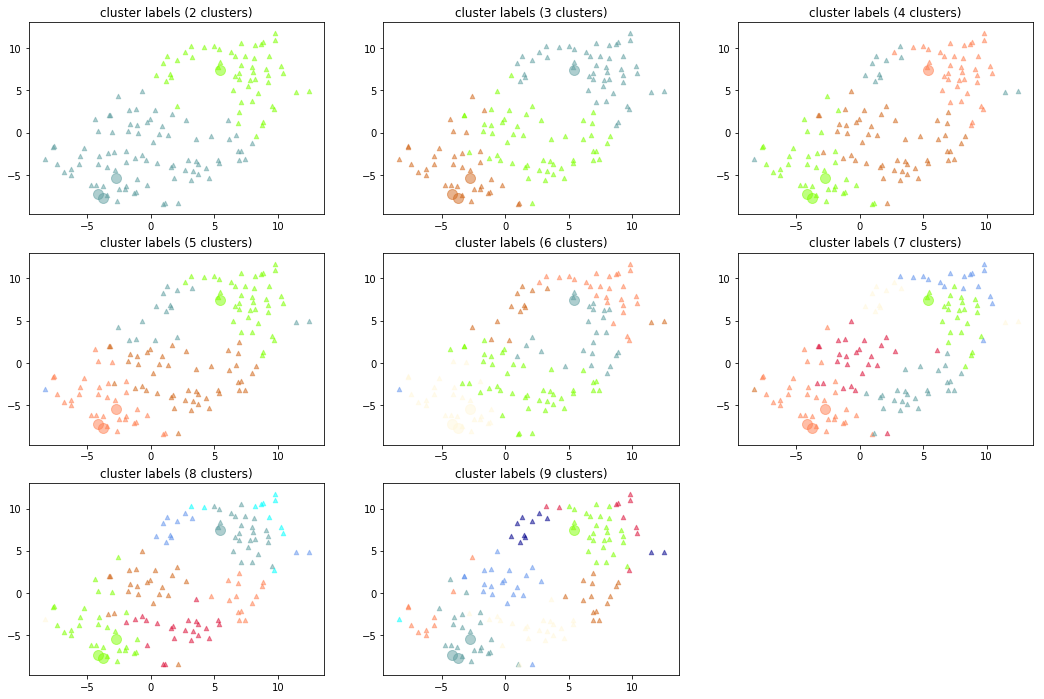

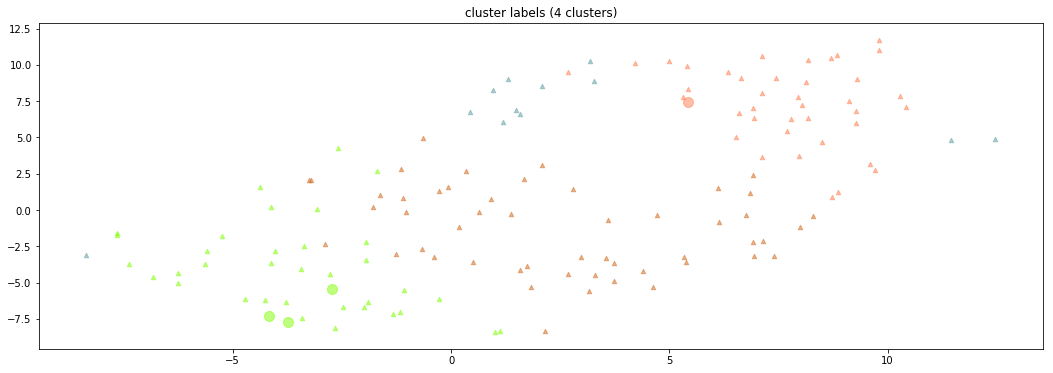

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,...,gev_RAJ2000,gev_DEJ2000,tev_fermi_names,tev_classes,tev_glat,tev_glon,tev_pos_dec,tev_pos_ra,marked,KMeans_clusters_4
12,0.014499,0.216198,0.331077,0.099187,0.322293,0.0,0.010681,0.002273,0.002087,0.000712,...,40.137901,61.228100,b'',b'bin',1.086135,135.675278,61.229336,40.131950,1,1
44,0.006512,0.225784,0.309710,0.088960,0.355733,0.0,0.003307,0.002040,0.001594,0.002120,...,154.729904,-58.945599,b'1FGL J1018.6-5856',b'bin',-1.779517,284.314087,-59.000001,154.575002,1,1
112,0.007598,0.117064,0.309349,0.034505,0.203540,0.0,0.118844,0.094852,0.067791,0.035185,...,276.568390,-14.847300,b'',b'bin',-1.289216,16.881586,-14.848400,276.562744,1,3
131,0.022409,0.362261,0.111730,0.253947,0.249653,0.0,0.000000,0.000000,0.000000,0.000000,...,308.059814,41.446899,b'',b'unid',1.111117,80.299477,41.567007,308.025009,1,1


0 cluster (#5F9EA0)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
1,b' ',b'snr ',b'',b'snr',[],[],0,0
11,b' ',b'bll ',b'',b'hbl',[],[],0,0
17,b' ',b'bll ',b'',b'hbl',[],[],0,0
22,b' ',b' ',b'',"b'snr,mc'","[""b'UCAC2 1674039'"" ""b'UCAC4 102-012036'"" ""b...",['Be' 'Be' 'B' 'B'],1,0
41,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',[],[],0,0
48,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',[],[],0,0
55,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',[],[],0,0
63,b' ',b'PSR ',b'',b'pwn',[],[],0,0
75,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',[],[],0,0
76,b'1FGL J1513.2-5904 ',b'PSR ',b'',b'pwn',"[""b'Cl* Pismis 20 PPM 130'"" ""b'Cl Pis...",['B0Ve'],1,0


1 cluster (#7FFF00)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
7,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',[],[],0,0
12,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',"[""b'BD+60 529'"" ""b'EM* MWC 56'"" ""b'LS I ...",['B' 'B' 'B0Ve' 'B0Ve'],1,1
14,b' ',b'rdg ',b'',b'hbl',[],[],0,0
20,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',[],[],0,0
23,b' ',b'PWN ',b'',b'psr',[],[],0,0
24,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',[],[],0,0
27,b' ',b'bll ',b'',b'hbl',[],[],0,0
29,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",[],[],0,0
36,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',[],[],0,0
39,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',[],[],0,0


2 cluster (#D2691E)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
0,b' ',b'bll ',b'',b'hbl',[],[],0,0
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',[],[],0,0
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',"[""b'LS I +59 48'""]",['B'],1,0
4,b'1FGL J0047.3-2512 ',b'sbg ',b'',b'galaxy',[],[],0,0
5,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',[],[],0,0
8,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',[],[],0,0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',[],[],0,0
10,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',[],[],0,0
13,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',[],[],0,0
15,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',[],[],0,0


3 cluster (#FF7F50)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
6,b' ',b'bll ',b'',b'hbl',[],[],0,0
21,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',[],[],0,0
25,b' ',b'PWN ',b'',b'pwn',[],[],0,0
32,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',[],[],0,0
35,b' ',b'PWN ',b'',b'pwn',[],[],0,0
37,b'1FGL J0854.0-4632 ',b'SNR ',"b'1FGL J0854.0-4632,2FGL J0851.7-4635,3FGL J08...",b'snr',[],[],0,0
40,b' ',b'bll ',b'',b'hbl',[],[],0,0
47,b' ',b' ',b'',b'pwn',[],[],0,0
49,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',[],[],0,0
51,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',[],[],0,0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.090295,0.052197,0.103926,0.049796,0.083543,0.0,0.170795,0.044344,0.036003,0.067215,0.301886
1,0.079153,0.249093,0.231421,0.148062,0.276996,0.0,0.006364,0.003314,0.002425,0.001745,0.001427
2,0.138634,0.193287,0.187723,0.176413,0.194330,0.0,0.070512,0.019833,0.010675,0.006161,0.002432
3,0.129958,0.112974,0.106970,0.109008,0.112388,0.0,0.157813,0.096854,0.073306,0.050543,0.050185


In [28]:
spectra_2D  = build_images_KMeans(spectra, spectrum_columns, spectra_distances, colors, TSNE_learning_rate=500, TSNE_n_iter=1500, TSNE_learning_rate2=300)
list_spectra_clusters, centers = print_clusters_structure_KMeans(spectra, spectrum_columns, other_names, spectra_distances, 4, colors, spectra_2D)
for i in range(len(list_spectra_clusters)):
    print("{} cluster ({})".format(i, colors[i]))
    display(list_spectra_clusters[i])
print("centroids:")
display(centers)

[0.25, 0.17, 0.11, 0.07, 0.05, 0.03, 0.02, 0.01]


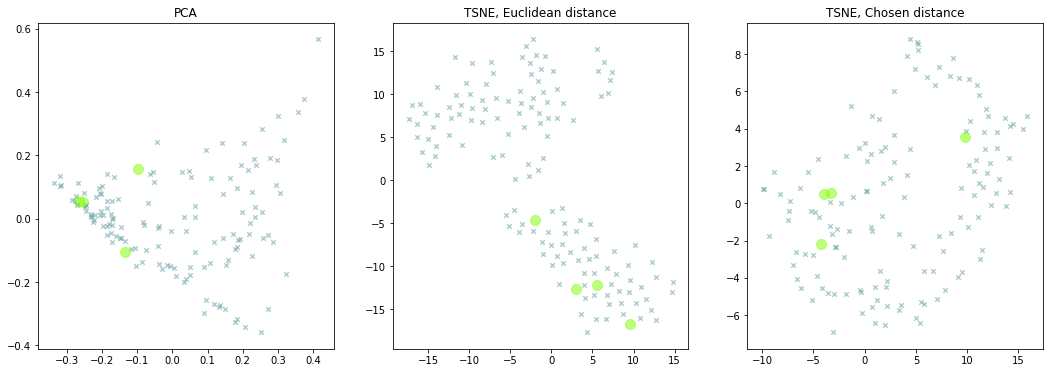

Clustering


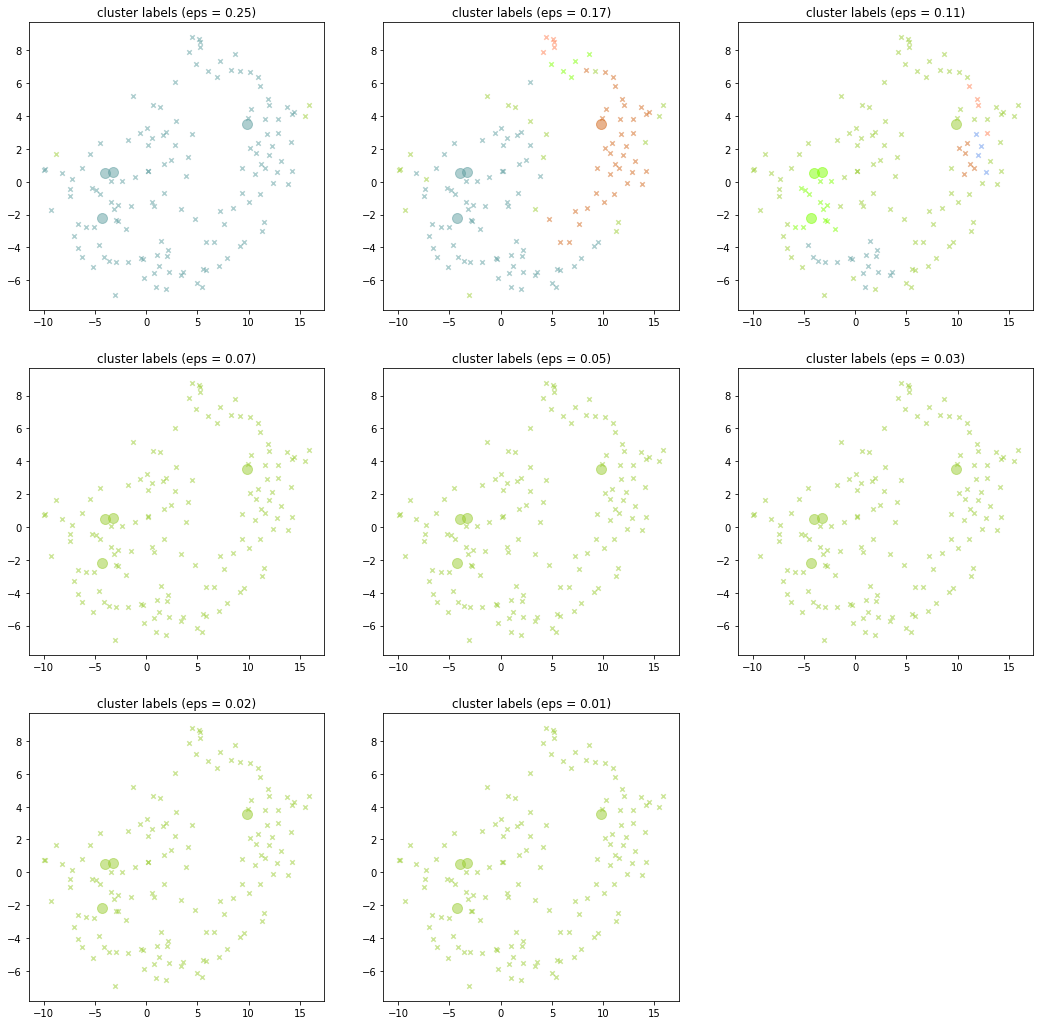

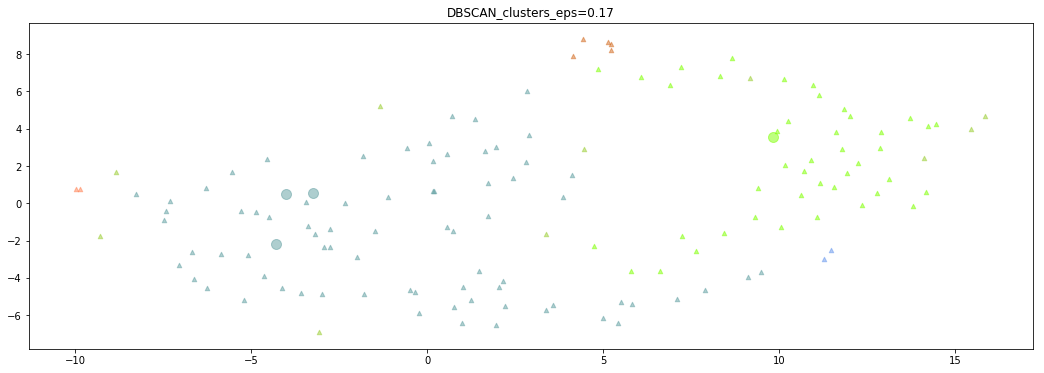

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,...,gev_RAJ2000,gev_DEJ2000,tev_fermi_names,tev_classes,tev_glat,tev_glon,tev_pos_dec,tev_pos_ra,marked,DBSCAN_clusters_eps=0.17
12,0.014499,0.216198,0.331077,0.099187,0.322293,0.0,0.010681,0.002273,0.002087,0.000712,...,40.137901,61.228100,b'',b'bin',1.086135,135.675278,61.229336,40.131950,1,0
44,0.006512,0.225784,0.309710,0.088960,0.355733,0.0,0.003307,0.002040,0.001594,0.002120,...,154.729904,-58.945599,b'1FGL J1018.6-5856',b'bin',-1.779517,284.314087,-59.000001,154.575002,1,0
112,0.007598,0.117064,0.309349,0.034505,0.203540,0.0,0.118844,0.094852,0.067791,0.035185,...,276.568390,-14.847300,b'',b'bin',-1.289216,16.881586,-14.848400,276.562744,1,1
131,0.022409,0.362261,0.111730,0.253947,0.249653,0.0,0.000000,0.000000,0.000000,0.000000,...,308.059814,41.446899,b'',b'unid',1.111117,80.299477,41.567007,308.025009,1,0


0 cluster (#5F9EA0)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
0,b' ',b'bll ',b'',b'hbl',[],[],0,0
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',[],[],0,0
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',"[""b'LS I +59 48'""]",['B'],1,0
4,b'1FGL J0047.3-2512 ',b'sbg ',b'',b'galaxy',[],[],0,0
5,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',[],[],0,0
7,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',[],[],0,0
8,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',[],[],0,0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',[],[],0,0
10,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',[],[],0,0
12,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',"[""b'BD+60 529'"" ""b'EM* MWC 56'"" ""b'LS I ...",['B' 'B' 'B0Ve' 'B0Ve'],1,1


1 cluster (#7FFF00)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
1,b' ',b'snr ',b'',b'snr',[],[],0,0
6,b' ',b'bll ',b'',b'hbl',[],[],0,0
19,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',[],[],0,0
25,b' ',b'PWN ',b'',b'pwn',[],[],0,0
34,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',[],[],0,0
35,b' ',b'PWN ',b'',b'pwn',[],[],0,0
40,b' ',b'bll ',b'',b'hbl',[],[],0,0
47,b' ',b' ',b'',b'pwn',[],[],0,0
49,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',[],[],0,0
51,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',[],[],0,0


2 cluster (#D2691E)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
17,b' ',b'bll ',b'',b'hbl',[],[],0,0
22,b' ',b' ',b'',"b'snr,mc'","[""b'UCAC2 1674039'"" ""b'UCAC4 102-012036'"" ""b...",['Be' 'Be' 'B' 'B'],1,0
41,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',[],[],0,0
48,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',[],[],0,0
79,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',[],[],0,0


3 cluster (#FF7F50)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
20,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',[],[],0,0
62,b'1FGL J1325.6-4300 ',b'RDG ',b'',b'fri',[],[],0,0


4 cluster (#6495ED)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
80,b'1FGL J1614.7-5138c',b'spp ',b'',b'unid',"[""b'MSX6C G331.5487-00.5364'"" ""b'MSX6C G331.54...",['Be' 'B' 'B0Ve'],1,0
84,b'1FGL J1640.8-4634c',b'spp ',b'',b'pwn',[],[],0,0


5 cluster (#FFF8DC)


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,s_MAIN_ID,s_class,s_simbad,marked
11,b' ',b'bll ',b'',b'hbl',[],[],0,0
32,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',[],[],0,0
37,b'1FGL J0854.0-4632 ',b'SNR ',"b'1FGL J0854.0-4632,2FGL J0851.7-4635,3FGL J08...",b'snr',[],[],0,0
70,b'1FGL J1443.8+2457 ',b'fsrq ',b'3FGL J1443.9+2502',b'fsrq',[],[],0,0
75,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',[],[],0,0
86,b' ',b'spp ',b'',b'unid',[],[],0,0
90,b'1FGL J1717.9-3729c',b'snr ',b'',"b'snr,mc'",[],[],0,0
96,b' ',b' ',b'',b'unid',"[""b'SSTGC 519103'"" ""b'SSTGC 519103'"" ""b'GCIRS ...",['Be' 'B' 'B' 'O'],1,0
101,b'1FGL J1800.5-2359c',b' ',b'',"b'snr,mc'",[],[],0,0
113,b' ',b' ',b'',b'bin',"[""b'LS IV -14 55'"" ""b'BD-14 5047'"" ""b'V* V...",['B' 'B0Ve' 'B0Ve'],1,0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.108764,0.222812,0.212247,0.163409,0.235708,0.0,0.038610,0.009132,0.004531,0.003155,0.001632
1,0.123995,0.116208,0.118582,0.114683,0.119607,0.0,0.166414,0.082773,0.060586,0.043589,0.053564
2,0.169085,0.051186,0.011159,0.065171,0.039534,0.0,0.059296,0.024707,0.034945,0.113516,0.431401
3,0.301620,0.098718,0.307294,0.128982,0.163386,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.167351,0.172731,0.001752,0.146426,0.111225,0.0,0.155665,0.121176,0.094654,0.026637,0.002383
5,0.063728,0.117720,0.144704,0.091262,0.153992,0.0,0.125838,0.082353,0.061763,0.042401,0.116239


In [29]:
eps_l = [0.01 * int(1.5**i) for i in range(8, 0, -1)]
print(eps_l)
spectra_2D = build_images_DBSCAN(spectra, spectrum_columns, spectra_distances, colors, eps_l=eps_l, TSNE_learning_rate=200, TSNE_n_iter=300, TSNE_learning_rate2=200)
list_spectra_clusters, centers = print_clusters_structure_DBSCAN(spectra, spectrum_columns, other_names, spectra_distances, 0.17, colors, spectra_2D)
for i in range(len(list_spectra_clusters)):
    print("{} cluster ({})".format(i, colors[i]))
    display(list_spectra_clusters[i])
print("centroids:")
display(centers)